In [ ]:
%run processed-imdb-wiki-dataset/mat.py

time data '829-09-08' does not match format '%Y-%m-%d'
time data '1823-12-00' does not match format '%Y-%m-%d'
time data '1953-10-00' does not match format '%Y-%m-%d'
time data '1984-15-03' does not match format '%Y-%m-%d'
time data '1963-02-00' does not match format '%Y-%m-%d'
time data '1977-04-00' does not match format '%Y-%m-%d'
time data '1946-05-00' does not match format '%Y-%m-%d'
time data '647-05-15' does not match format '%Y-%m-%d'
time data '11-03-00' does not match format '%Y-%m-%d'
time data '1980-05-00' does not match format '%Y-%m-%d'
time data '1960-02-00' does not match format '%Y-%m-%d'
time data '1975-03-00' does not match format '%Y-%m-%d'
time data '1952-11-00' does not match format '%Y-%m-%d'
time data '1974-04-00' does not match format '%Y-%m-%d'
time data '1996-25-05' does not match format '%Y-%m-%d'
time data '1914-02-00' does not match format '%Y-%m-%d'


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
LINK_PREFIX = "/content/gdrive/My Drive/Colab Notebooks/CZ4042 Project"

In [ ]:
!unzip -q '/content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/wiki_crop.zip'

replace wiki_crop/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Load Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
df = pd.read_csv('{}/meta.csv'.format(LINK_PREFIX))
df

,gender,path
0,male,wiki_crop/47/30034447_1957-04-20_2011.jpg
1,female,wiki_crop/80/291380_1959-03-11_2013.jpg
2,female,wiki_crop/34/41282534_1994-03-10_2015.jpg
3,male,wiki_crop/64/2446664_1978-10-26_2008.jpg
4,female,wiki_crop/94/24841994_1955-06-11_1981.jpg
...,...,...
40211,male,wiki_crop/33/36348433_1986-05-28_2012.jpg
40212,male,wiki_crop/69/983669_1944-11-14_2006.jpg
40213,male,wiki_crop/62/18151562_1926-05-19_1954.jpg
40214,male,wiki_crop/95/8095_1938-01-10_2005.jpg


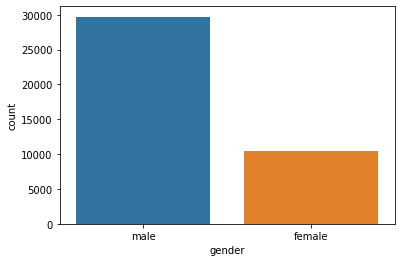

In [ ]:
sns.countplot(x=df['gender'])
plt.show()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0, stratify=df['gender'])
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=0, stratify=train_df['gender'])

In [ ]:
image_size = 224

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
def save_history():
    hist_out_file = open("{}/histories_nithya.pickle".format(LINK_PREFIX), "wb")
    pickle.dump(histories, hist_out_file)
    hist_out_file.close()

def open_history():
    try:
        file = open("{}/histories_nithya.pickle".format(LINK_PREFIX), 'rb')
        pickleData = pickle.load(file)
        file.close()
    except (OSError, IOError) as e:
        pickleData = {}
        pickle.dump(pickleData, open("{}/histories_nithya.pickle".format(LINK_PREFIX), "wb"))
    return pickleData

In [ ]:
histories = open_history()
histories.keys()

dict_keys(['EfficientNetB0', 'xception', 'vgg16', 'vgg19', 'vgg16_stacked', 'vgg16_drop-rate:0', 'vgg16_drop-rate:0.2', 'vgg16_lr:0.01', 'vgg16_lr:0.0001', 'vgg16_batch-size:64', 'vgg16_batch-size:256', 'non_transferLearning_model', 'vgg16_optimal'])

# Models

In [ ]:
# data generator for training data
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col="path", y_col="gender", 
                                                    target_size=(224,224), batch_size=128, 
                                                    class_mode='binary')

# data generator for validation data
validation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=128, 
                                                              class_mode='binary')

# data generator for visualising data
visualisation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=128, 
                                                              class_mode='binary', shuffle=False)

# data generator for testing data
test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  x_col="path", y_col="gender", 
                                                  target_size=(224,224), batch_size=128, 
                                                  class_mode='binary', shuffle = False)

Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import json

In [ ]:
def mc(title):
    return ModelCheckpoint('{}/weights/{}.h5'.format(LINK_PREFIX, title), 
                           monitor='val_acc', mode='max', verbose=1, save_best_only=True)

es = EarlyStopping(monitor='val_acc', mode='max', min_delta=0.001, verbose=1, patience=5, restore_best_weights=True)

In [ ]:
def build_model(tl_model):
    model = Sequential()
    model.add(tl_model)      
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=SGD(lr=1e-3, momentum=0.9),
                  metrics=['acc'])
    
    model.summary()
    return model

In [ ]:
def fit(model, title, epochs=50):
    h = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples/train_generator.batch_size, 
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples/validation_generator.batch_size,
                    verbose=1,
                    callbacks=[es, mc(title)])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    ax1.plot(h.history["loss"], label="Training")
    ax1.plot(h.history["val_loss"], label="Validation")
    ax1.set_xlabel("# Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="best")

    ax2.plot(h.history["acc"], label="Training")
    ax2.plot(h.history["val_acc"], label="Validation")
    ax2.set_xlabel("# Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="best")

    fig.suptitle("{} Model Metrics".format(title))
    plt.savefig("{}/img/{}_Model-Metrics.jpg".format(LINK_PREFIX, title))

    plt.show()
    
    histories[title] = h.history
    save_history()

In [ ]:
def model_analysis(model, title, save_path=LINK_PREFIX+"/results"):
    print('Results for {}'.format(title))
    prediction = model.predict(visualisation_generator,
                                steps=visualisation_generator.samples/visualisation_generator.batch_size,
                                verbose=1)
    predicted_classes = prediction.flatten()
    predicted_classes[predicted_classes>=0.5] = 1
    predicted_classes[predicted_classes<0.5] = 0
    
    actual = visualisation_generator.classes
    errors = np.where(predicted_classes != actual)[0]
    print("Error rate {}".format(len(errors)/visualisation_generator.samples))
    
    genders = ['Female', 'Male']
    cm = confusion_matrix(actual, predicted_classes)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt="d",
                xticklabels=genders, yticklabels=genders)
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.savefig('{}/{}_cm.pdf'.format(save_path, title))
    plt.close()
    
    print(classification_report(actual, predicted_classes, target_names=genders))
    clsf_report = pd.DataFrame(classification_report(actual, predicted_classes, target_names=genders, output_dict=True)).transpose()
    clsf_report.to_csv('{}/{}_cr.csv'.format(save_path, title), index= True)

    # Get AUC ROC Score and save as a file
    roc_auc = roc_auc_score(actual, predicted_classes)
    roc_auc_file = '{}/{}_roc_auc'.format(save_path, title)
    params = {'title': title,
                'roc_auc': roc_auc}
    with open(roc_auc_file, 'w') as fp:
        json.dump(params, fp)
    print("Successfully saved auc_roc file at {}".format(roc_auc_file))

## Non Transfer Learning Model

In [ ]:
model = Sequential()

model.add(layers.Conv2D(7, 5, strides=4, input_shape=(224, 224, 3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(3))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(5, 3, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(3))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(5, 3, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(3))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-3, momentum=0.9),
              metrics=['acc'])
    
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 55, 55, 7)         532       
_________________________________________________________________
batch_normalization_7 (Batch (None, 55, 55, 7)         28        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 7)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 18, 18, 7)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 5)         320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 5)         20        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 5)          

Epoch 1/1000
176/175 [==============================] - ETA: 0s - loss: 0.6701 - acc: 0.6246
Epoch 00001: val_acc improved from -inf to 0.73923, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/non_transferLearning_model.h5
176/175 [==============================] - 61s 347ms/step - loss: 0.6701 - acc: 0.6246 - val_loss: 0.5890 - val_acc: 0.7392
Epoch 2/1000
176/175 [==============================] - ETA: 0s - loss: 0.6224 - acc: 0.7002
Epoch 00002: val_acc did not improve from 0.73923
176/175 [==============================] - 61s 347ms/step - loss: 0.6224 - acc: 0.7002 - val_loss: 0.5795 - val_acc: 0.7392
Epoch 3/1000
176/175 [==============================] - ETA: 0s - loss: 0.6052 - acc: 0.7187
Epoch 00003: val_acc did not improve from 0.73923
176/175 [==============================] - 61s 348ms/step - loss: 0.6052 - acc: 0.7187 - val_loss: 0.5741 - val_acc: 0.7392
Epoch 4/1000
176/175 [==============================] - ETA: 0s - loss: 0.5997 - acc: 0

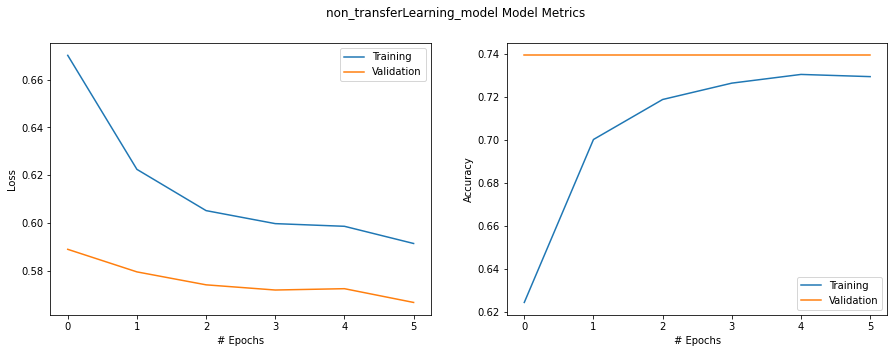

In [ ]:
fit(model, "non_transferLearning_model", epochs=1000)

## VGG16

In [ ]:
from keras.applications import VGG16

In [ ]:
vgg16_net = VGG16(weights='imagenet', include_top=False, input_tensor=None, input_shape=(224,224,3))
vgg16_net.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
for layer in vgg16_net.layers[:-5]:
  layer.trainable = False

In [ ]:
model = build_model(vgg16_net)
model.load_weights(LINK_PREFIX+"/weights/vgg16.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 40,406,849
Trainable params: 32,771,585
Non-trainable params: 7,635,264
_________________________________________________________________


Epoch 1/50
176/175 [==============================] - ETA: 0s - loss: 0.3835 - acc: 0.8405
Epoch 00001: val_acc improved from -inf to 0.88344, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/vgg16.h5
176/175 [==============================] - 149s 847ms/step - loss: 0.3835 - acc: 0.8405 - val_loss: 0.2932 - val_acc: 0.8834
Epoch 2/50
176/175 [==============================] - ETA: 0s - loss: 0.2806 - acc: 0.8911
Epoch 00002: val_acc improved from 0.88344 to 0.89857, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/vgg16.h5
176/175 [==============================] - 141s 799ms/step - loss: 0.2806 - acc: 0.8911 - val_loss: 0.2639 - val_acc: 0.8986
Epoch 3/50
176/175 [==============================] - ETA: 0s - loss: 0.2531 - acc: 0.9049
Epoch 00003: val_acc did not improve from 0.89857
176/175 [==============================] - 140s 794ms/step - loss: 0.2531 - acc: 0.9049 - val_loss: 0.2640 - val_acc: 0.8984
Epoch 4/50
176/17

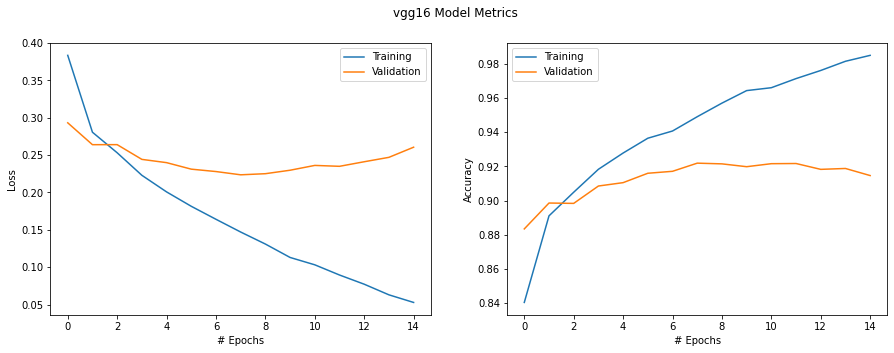

In [ ]:
fit(model, "vgg16")

In [ ]:
model_analysis(model, "vgg16")

Results for vgg16
76/75 [==============================] - 37s 484ms/step
Error rate 0.37339411520928306
              precision    recall  f1-score   support

      Female       0.25      0.22      0.23      2517
        Male       0.74      0.77      0.75      7135

    accuracy                           0.63      9652
   macro avg       0.49      0.49      0.49      9652
weighted avg       0.61      0.63      0.62      9652

Successfully saved auc_roc file at /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/results/vgg16_roc_auc


## Xception

In [ ]:
from keras.applications import Xception

In [ ]:
xception_model = Xception(weights='imagenet', include_top=False, input_tensor=None, input_shape=(224,224,3))
xception_model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [ ]:
for layer in xception_model.layers[:-6]:
  layer.trainable = False

In [ ]:
model = build_model(xception_model)
model.load_weights(LINK_PREFIX+"/weights/xception.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 123,623,977
Trainable params: 107,511,297
Non-trainable params: 16,112,680
_________________________________________________________________


Epoch 1/50
176/175 [==============================] - ETA: 0s - loss: 0.3108 - acc: 0.8760
Epoch 00001: val_acc improved from -inf to 0.89671, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/xception.h5
176/175 [==============================] - 159s 904ms/step - loss: 0.3108 - acc: 0.8760 - val_loss: 0.2888 - val_acc: 0.8967
Epoch 2/50
176/175 [==============================] - ETA: 0s - loss: 0.2473 - acc: 0.9067
Epoch 00002: val_acc improved from 0.89671 to 0.90199, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/xception.h5
176/175 [==============================] - 157s 891ms/step - loss: 0.2473 - acc: 0.9067 - val_loss: 0.2610 - val_acc: 0.9020
Epoch 3/50
176/175 [==============================] - ETA: 0s - loss: 0.2172 - acc: 0.9197
Epoch 00003: val_acc improved from 0.90199 to 0.90448, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/xception.h5
176/175 [==============================

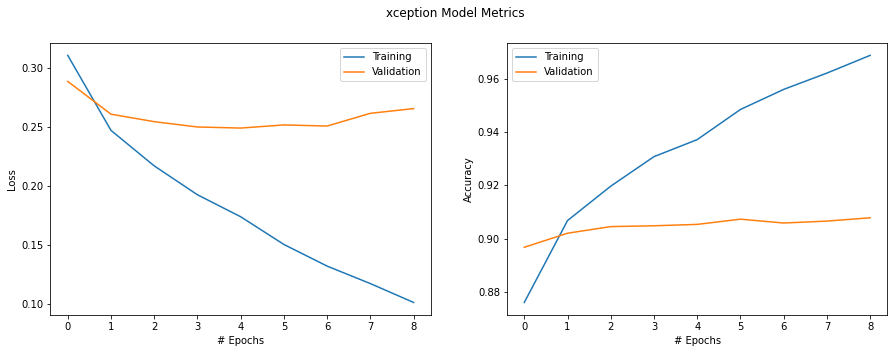

In [ ]:
fit(model, "xception")

63/62 [==============================] - 38s 599ms/step
Error rate 0.09323719542516161


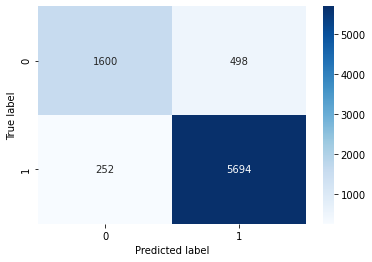

              precision    recall  f1-score   support

      Female       0.86      0.76      0.81      2098
        Male       0.92      0.96      0.94      5946

    accuracy                           0.91      8044
   macro avg       0.89      0.86      0.87      8044
weighted avg       0.91      0.91      0.90      8044



In [ ]:
analyse(model, "xception")

In [ ]:
model_analysis(model, "xception")

Results for xception
76/75 [==============================] - 39s 517ms/step
Error rate 0.37588064649813513
              precision    recall  f1-score   support

      Female       0.26      0.23      0.24      2517
        Male       0.74      0.76      0.75      7135

    accuracy                           0.62      9652
   macro avg       0.50      0.50      0.50      9652
weighted avg       0.61      0.62      0.62      9652

Successfully saved auc_roc file at /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/results/xception_roc_auc


## EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
eNetB0_conv = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=None, input_shape=(224,224,3))
eNetB0_conv.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
____________________

In [ ]:
for layer in eNetB0_conv.layers[:-16]:
  layer.trainable = False

In [ ]:
model = build_model(eNetB0_conv)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              64226304  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 68,276,900
Trainable params: 65,356,721
Non-trainable params: 2,920,179
_________________________________________________________________


Epoch 1/30
176/175 [==============================] - ETA: 0s - loss: 0.6372 - acc: 0.7060
Epoch 00001: val_acc improved from -inf to 0.73923, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/EfficientNetB0.h5
176/175 [==============================] - 87s 496ms/step - loss: 0.6372 - acc: 0.7060 - val_loss: 0.6761 - val_acc: 0.7392
Epoch 2/30
176/175 [==============================] - ETA: 0s - loss: 0.5985 - acc: 0.7309
Epoch 00002: val_acc did not improve from 0.73923
176/175 [==============================] - 84s 475ms/step - loss: 0.5985 - acc: 0.7309 - val_loss: 0.5812 - val_acc: 0.7392
Epoch 3/30
176/175 [==============================] - ETA: 0s - loss: 0.5888 - acc: 0.7354
Epoch 00003: val_acc did not improve from 0.73923
176/175 [==============================] - 82s 465ms/step - loss: 0.5888 - acc: 0.7354 - val_loss: 0.5983 - val_acc: 0.7392
Epoch 4/30
176/175 [==============================] - ETA: 0s - loss: 0.5856 - acc: 0.7365
Epoch 00004: v

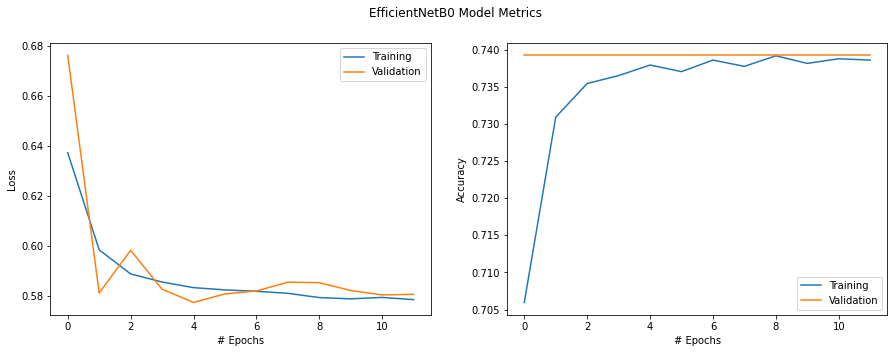

In [ ]:
fit(model, "EfficientNetB0")

63/62 [==============================] - 20s 314ms/step
Error rate 0.26081551466931874


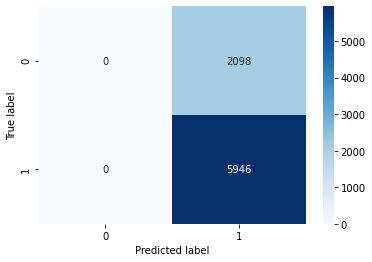

              precision    recall  f1-score   support

      Female       0.00      0.00      0.00      2098
        Male       0.74      1.00      0.85      5946

    accuracy                           0.74      8044
   macro avg       0.37      0.50      0.43      8044
weighted avg       0.55      0.74      0.63      8044



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
analyse(model, "EfficientNetB0")

## NasNetLarge

In [ ]:
from keras.applications import NASNetLarge

In [ ]:
nnlarge = NASNetLarge(include_top=False, weights='imagenet', input_shape=(224,224,3))
nnlarge.summary()

ValueError: ignored

In [ ]:
for layer in nnlarge.layers[:-5]:
  layer.trainable = False

In [ ]:
model = build_model(nnlarge)

In [ ]:
fit(model, "NasNetLarge")

In [ ]:
analyse(model, "NasNetLarge")

## VGG19

In [ ]:
from keras.applications import VGG19

In [ ]:
vgg19_net = VGG19(weights='imagenet', include_top=False, input_tensor=None, input_shape=(224,224,3))
vgg19_net.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
for layer in vgg19_net.layers[:-5]:
  layer.trainable = False

In [ ]:
model = build_model(vgg19_net)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1025      
Total params: 45,716,545
Trainable params: 35,131,393
Non-trainable params: 10,585,152
_________________________________________________________________


Epoch 1/50
176/175 [==============================] - ETA: 0s - loss: 0.3862 - acc: 0.8397
Epoch 00001: val_acc improved from -inf to 0.86749, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/vgg19.h5
176/175 [==============================] - 171s 971ms/step - loss: 0.3862 - acc: 0.8397 - val_loss: 0.3282 - val_acc: 0.8675
Epoch 2/50
176/175 [==============================] - ETA: 0s - loss: 0.2812 - acc: 0.8916
Epoch 00002: val_acc improved from 0.86749 to 0.87930, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/vgg19.h5
176/175 [==============================] - 170s 967ms/step - loss: 0.2812 - acc: 0.8916 - val_loss: 0.3035 - val_acc: 0.8793
Epoch 3/50
176/175 [==============================] - ETA: 0s - loss: 0.2428 - acc: 0.9071
Epoch 00003: val_acc improved from 0.87930 to 0.89919, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/vgg19.h5
176/175 [==============================] - 170s 

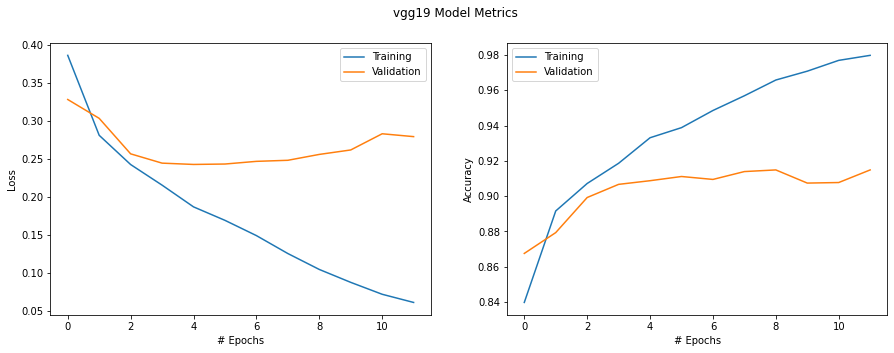

In [ ]:
fit(model, "vgg19")

63/62 [==============================] - 41s 657ms/step
Error rate 0.08254599701640974


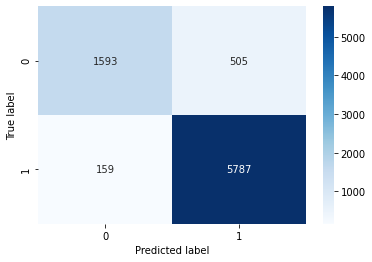

              precision    recall  f1-score   support

      Female       0.91      0.76      0.83      2098
        Male       0.92      0.97      0.95      5946

    accuracy                           0.92      8044
   macro avg       0.91      0.87      0.89      8044
weighted avg       0.92      0.92      0.91      8044



In [ ]:
analyse(model, "vgg19")

## GoogleNet

In [ ]:
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.models import Model

In [ ]:
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def googlenet():
    layer_in = Input(shape=(224,224,3))
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=1, activation='sigmoid', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=main)
    
    return model

In [ ]:
ggl_model = googlenet()
ggl_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_250 (Conv2D)             (None, 112, 112, 64) 9472        input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_58 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_250[0][0]                 
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 56, 56, 64)   256         max_pooling2d_58[0][0]           
____________________________________________________________________________________________

In [ ]:
ggl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
fit(ggl_model, "googlenet")

Epoch 1/30
175/175 [==============================] - 656s 4s/step - loss: 0.9270 - acc: 0.7345 - val_loss: 0.6378 - val_acc: 0.6587

Epoch 00001: val_acc improved from -inf to 0.65872, saving model to googlenet.h5
Epoch 2/30
175/175 [==============================] - 525s 3s/step - loss: 0.5245 - acc: 0.7576 - val_loss: 0.5520 - val_acc: 0.7337

Epoch 00002: val_acc improved from 0.65872 to 0.73373, saving model to googlenet.h5
Epoch 3/30
109/175 [=================>............] - ETA: 2:06 - loss: 0.4824 - acc: 0.7841

# HyperParam Optimisation

In [ ]:
from keras.applications import VGG16

In [ ]:
def build_baseline(drop_rate=0.5, lr=1e-3, stacked=False):
    vgg16_net = VGG16(weights='imagenet', include_top=False,
                      input_tensor=None, input_shape=(224,224,3))
    for layer in vgg16_net.layers[:-5]:
        layer.trainable = False

    model = Sequential()
    model.add(vgg16_net)      
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    if drop_rate != 0:
        model.add(layers.Dropout(drop_rate))
    if stacked:
        model.add(layers.Dense(1024, activation='relu'))
        model.add(layers.Dropout(drop_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=SGD(lr=lr, momentum=0.9),
                  metrics=['acc'])
    
    model.summary()
    return model

In [ ]:
def compare_metrics(hist, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    for lb, h in hist.items():
        l = len(h["val_loss"])
        x = np.linspace(0, l, l*5)

        # loss_BSpline = make_interp_spline([i for i in range(l)], h["val_loss"])
        # ax1.plot(x, loss_BSpline(x), label=lb)
        ax1.plot(h["val_loss"], label=lb)
        ax1.set_xlabel("# Epochs")
        ax1.set_ylabel("Val Loss")
        ax1.legend(loc="best")

        # acc_BSpline = make_interp_spline([i for i in range(l)], h["val_acc"])
        # ax2.plot(x, acc_BSpline(x), label=lb)
        ax2.plot(h["val_acc"], label=lb)
        ax2.set_xlabel("# Epochs")
        ax2.set_ylabel("Val Accuracy")
        ax2.legend(loc="best")

        fig.suptitle("{} Comparison".format(title))
        plt.savefig("{}/img/{} Comparison".format(LINK_PREFIX, title))

    plt.show()

## Learning Rate

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 1025      
Total params: 40,406,849
Trainable params: 32,771,585
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/50
176/175 [==============================] - ETA: 0s - loss: 0.4288 - acc: 0.8266
Epoch 000

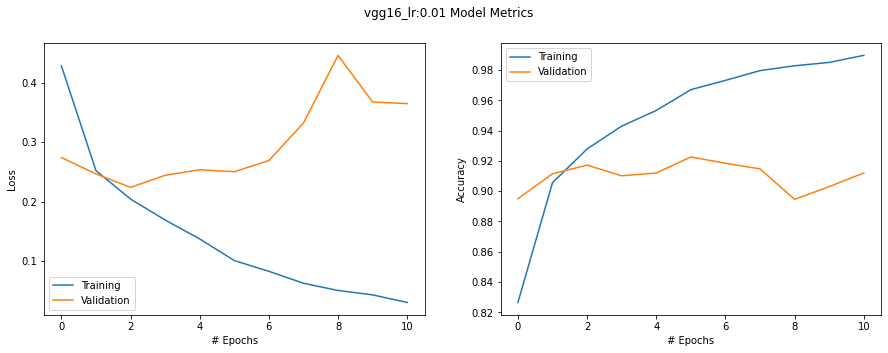

63/62 [==============================] - 31s 499ms/step
Error rate 0.08329189457981104


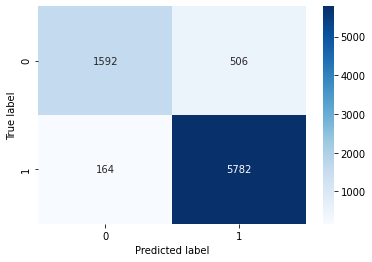

              precision    recall  f1-score   support

      Female       0.91      0.76      0.83      2098
        Male       0.92      0.97      0.95      5946

    accuracy                           0.92      8044
   macro avg       0.91      0.87      0.89      8044
weighted avg       0.92      0.92      0.91      8044

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________

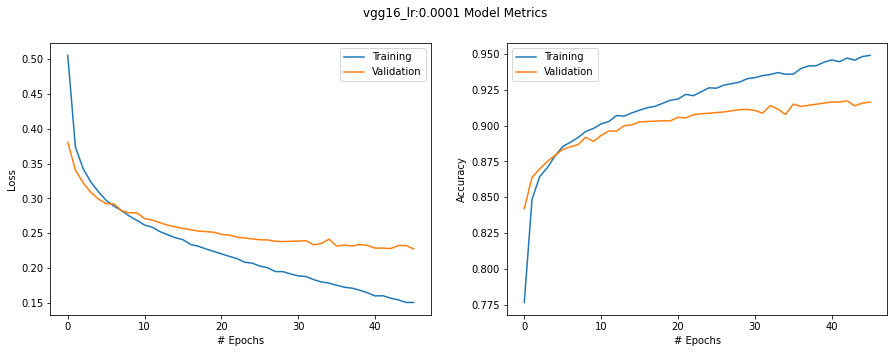

63/62 [==============================] - 31s 499ms/step
Error rate 0.07931377424167081


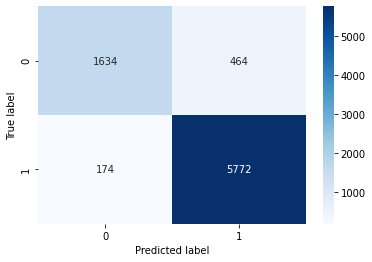

              precision    recall  f1-score   support

      Female       0.90      0.78      0.84      2098
        Male       0.93      0.97      0.95      5946

    accuracy                           0.92      8044
   macro avg       0.91      0.87      0.89      8044
weighted avg       0.92      0.92      0.92      8044



In [ ]:
title = "vgg16_lr:{}".format(1e-2)
model = build_baseline(lr=1e-2)
fit(model, title)
analyse(model, title)

title = "vgg16_lr:{}".format(1e-4)
model = build_baseline(lr=1e-4)
fit(model, title)
analyse(model, title)

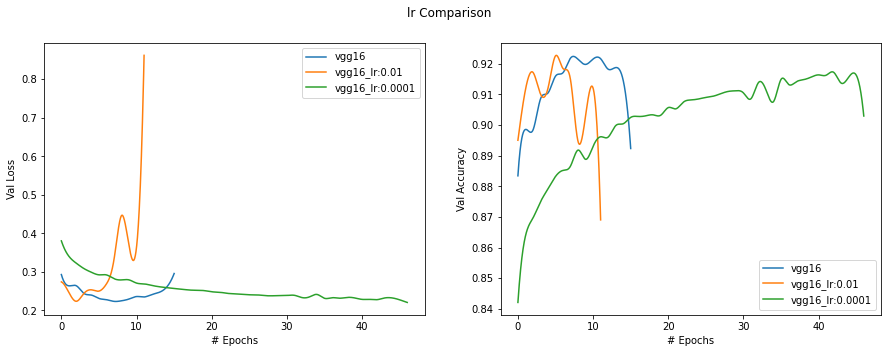

In [ ]:
titles = ["vgg16", "vgg16_lr:0.01", "vgg16_lr:0.0001"]
compare_metrics({x: histories[x] for x in titles}, "lr")

## Dropout

In [ ]:
DROP_RATES = [0, 0.2]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 1025      
Total params: 40,406,849
Trainable params: 32,771,585
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/50
176/175 [==============================] - ETA: 0s - loss: 0.3497 - acc: 0.8572
Epoch 00001: val_acc improved from -inf to 0.89018, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/vgg16_dro

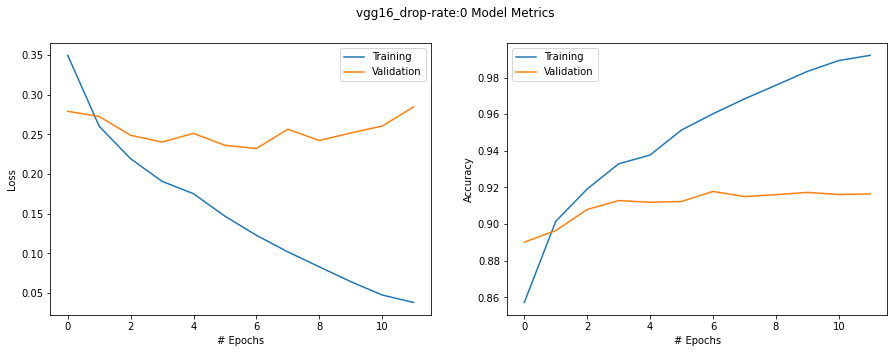

63/62 [==============================] - 31s 493ms/step
Error rate 0.07894082545997017


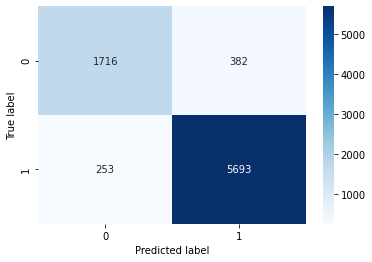

              precision    recall  f1-score   support

      Female       0.87      0.82      0.84      2098
        Male       0.94      0.96      0.95      5946

    accuracy                           0.92      8044
   macro avg       0.90      0.89      0.90      8044
weighted avg       0.92      0.92      0.92      8044

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________

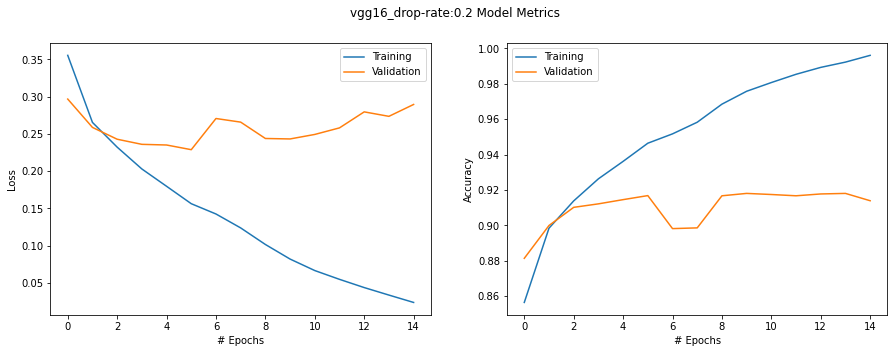

63/62 [==============================] - 31s 500ms/step
Error rate 0.07906514172053705


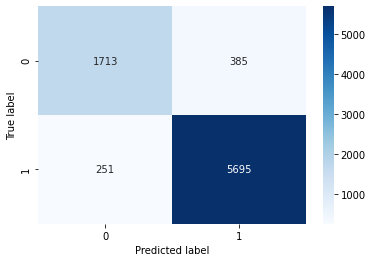

              precision    recall  f1-score   support

      Female       0.87      0.82      0.84      2098
        Male       0.94      0.96      0.95      5946

    accuracy                           0.92      8044
   macro avg       0.90      0.89      0.90      8044
weighted avg       0.92      0.92      0.92      8044



In [ ]:
for dr in DROP_RATES:
    title = "vgg16_drop-rate:{}".format(dr)
    model = build_baseline(drop_rate=dr)
    fit(model, title)
    analyse(model, title)

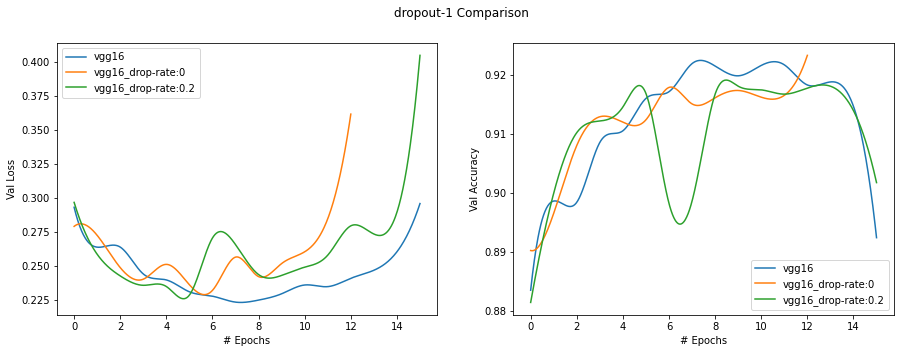

In [ ]:
titles = ["vgg16", "vgg16_drop-rate:0", "vgg16_drop-rate:0.2"]
compare_metrics({x: histories[x] for x in titles}, "dropout-1")

## Stacking Fully Connected Layers

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________

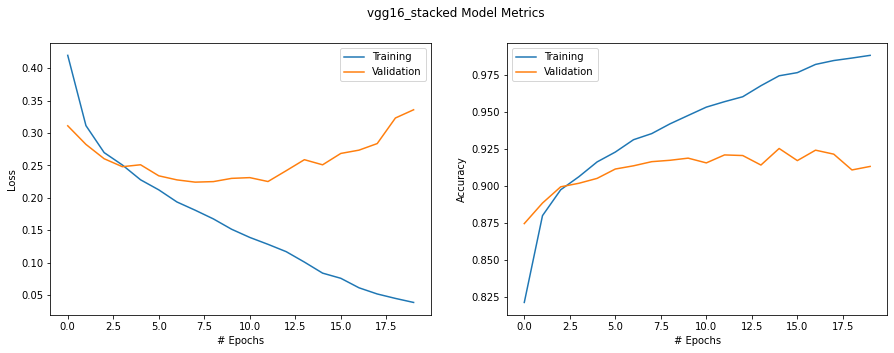

63/62 [==============================] - 35s 555ms/step
Error rate 0.07160616608652412


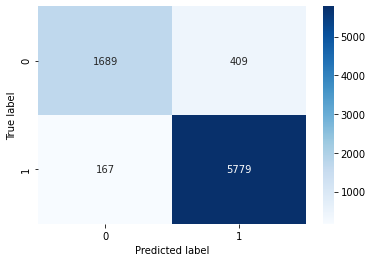

              precision    recall  f1-score   support

      Female       0.91      0.81      0.85      2098
        Male       0.93      0.97      0.95      5946

    accuracy                           0.93      8044
   macro avg       0.92      0.89      0.90      8044
weighted avg       0.93      0.93      0.93      8044



In [ ]:
title = "vgg16_stacked"
model = build_baseline(stacked=True)
fit(model, title)
analyse(model, title)

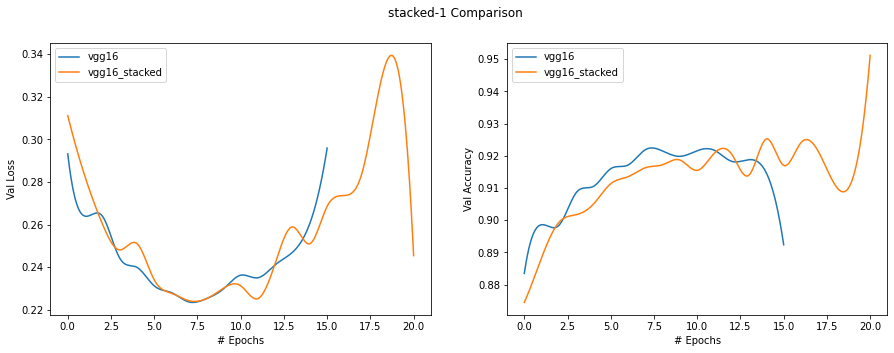

In [ ]:
titles = ["vgg16", "vgg16_stacked"]
compare_metrics({x: histories[x] for x in titles}, "stacked-1")

## Batch Size

In [ ]:
BATCH_SIZES = [64, 256]

Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.
58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total

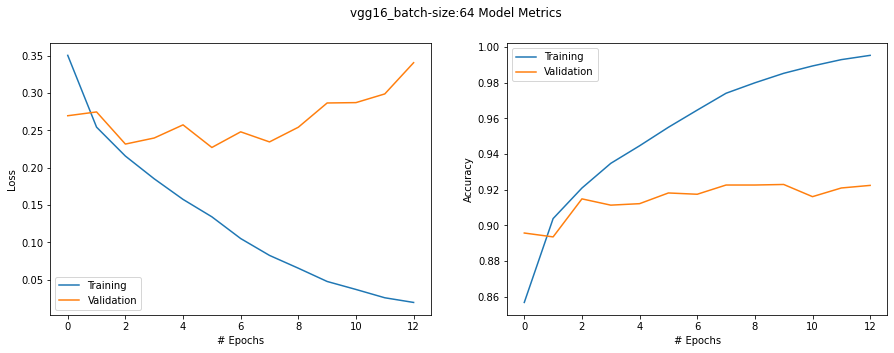

126/125 [==============================] - 33s 264ms/step
Error rate 0.07533565390353059


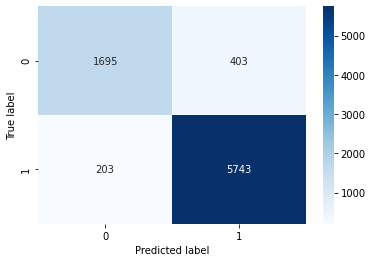

              precision    recall  f1-score   support

      Female       0.89      0.81      0.85      2098
        Male       0.93      0.97      0.95      5946

    accuracy                           0.92      8044
   macro avg       0.91      0.89      0.90      8044
weighted avg       0.92      0.92      0.92      8044

Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              25691136  
_____

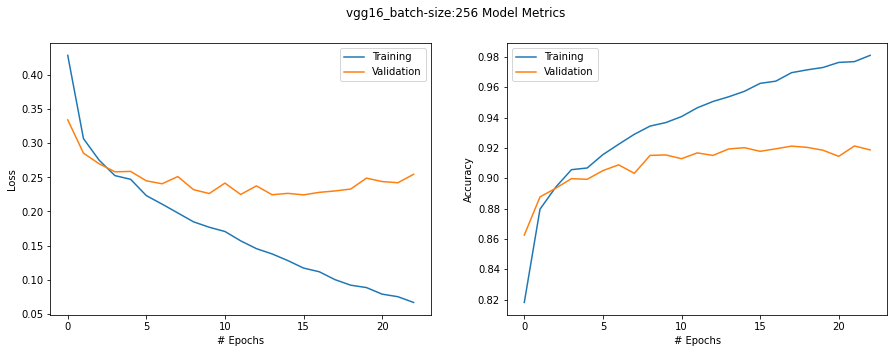

32/31 [==============================] - 37s 1s/step
Error rate 0.07707608155146693


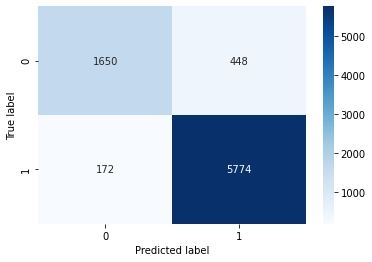

              precision    recall  f1-score   support

      Female       0.91      0.79      0.84      2098
        Male       0.93      0.97      0.95      5946

    accuracy                           0.92      8044
   macro avg       0.92      0.88      0.90      8044
weighted avg       0.92      0.92      0.92      8044



In [ ]:
for bs in BATCH_SIZES:
    title = "vgg16_batch-size:{}".format(bs)

    # data generator for training data
    train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                        x_col="path", y_col="gender", 
                                                        target_size=(224,224), batch_size=bs, 
                                                        class_mode='binary')

    # data generator for validation data
    validation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                                x_col="path", y_col="gender", 
                                                                target_size=(224,224), batch_size=bs, 
                                                                class_mode='binary')

    # data generator for testing data
    test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                    x_col="path", y_col="gender", 
                                                    target_size=(224,224), batch_size=bs, 
                                                    class_mode='binary', shuffle = False)
    
    model = build_baseline()
    fit(model, title)
    analyse(model, title)

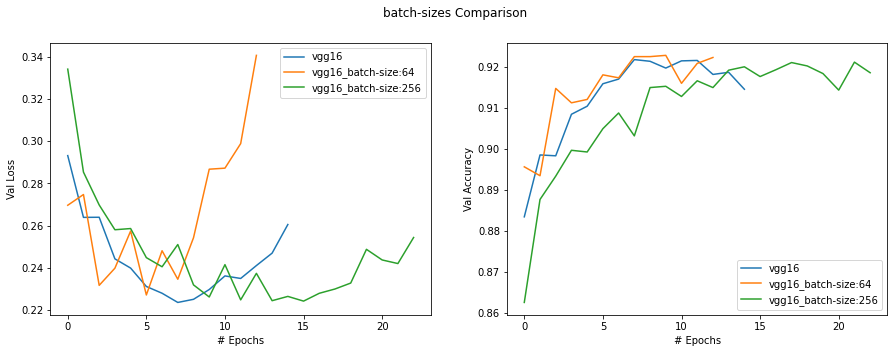

In [ ]:
titles = ["vgg16", "vgg16_batch-size:64", "vgg16_batch-size:256"]
compare_metrics({x: histories[x] for x in titles}, "batch-sizes")

## Overall Comparison

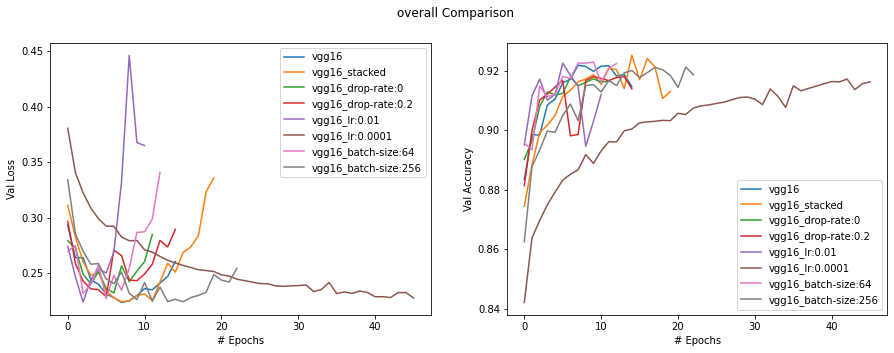

In [ ]:
titles = [t for t in histories.keys() if "vgg16" in t]
compare_metrics({x: histories[x] for x in titles}, "overall")

In [ ]:
# data generator for training data
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col="path", y_col="gender", 
                                                    target_size=(224,224), batch_size=64, 
                                                    class_mode='binary')

# data generator for validation data
validation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=64, 
                                                              class_mode='binary')

# data generator for visualising data
visualisation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=64, 
                                                              class_mode='binary', shuffle=False)

# data generator for testing data
test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  x_col="path", y_col="gender", 
                                                  target_size=(224,224), batch_size=64, 
                                                  class_mode='binary', shuffle = False)

Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

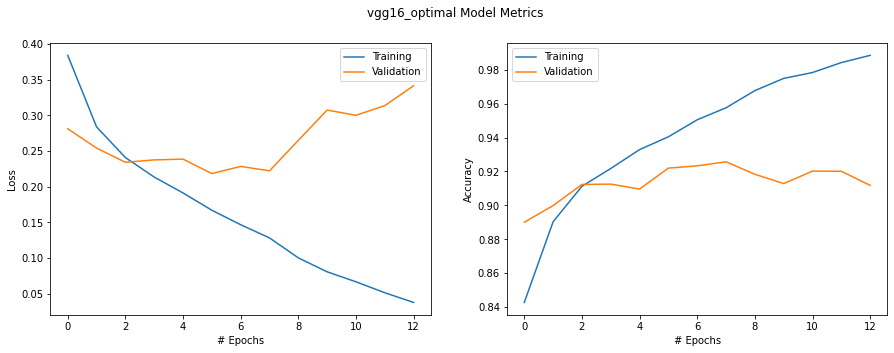

In [ ]:
title = "vgg16_optimal"
model = build_baseline(stacked=True)
fit(model, title)

In [ ]:
model_analysis(model, title)

Results for vgg16_optimal
151/150 [==============================] - 24s 157ms/step
Error rate 0.07428512225445504
              precision    recall  f1-score   support

      Female       0.91      0.79      0.85      2517
        Male       0.93      0.97      0.95      7135

    accuracy                           0.93      9652
   macro avg       0.92      0.88      0.90      9652
weighted avg       0.93      0.93      0.92      9652

Successfully saved auc_roc file at /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/results/vgg16_optimal_roc_auc


# Finetuning of Transfer Learning

In [ ]:
from keras.models import load_model

In [ ]:
# data generator for training data
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col="path", y_col="gender", 
                                                    target_size=(224,224), batch_size=64, 
                                                    class_mode='binary')

# data generator for validation data
validation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=64, 
                                                              class_mode='binary')

# data generator for visualising data
visualisation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=64, 
                                                              class_mode='binary', shuffle=False)

# data generator for testing data
test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  x_col="path", y_col="gender", 
                                                  target_size=(224,224), batch_size=64, 
                                                  class_mode='binary', shuffle = False)

Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.


## Unfreeze All Layers

In [ ]:
model = load_model("{}/weights/vgg16_optimal.h5".format(LINK_PREFIX))
model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in model.layers[0].layers:
    layer.trainable = True

print("Total trainable weights: {}".format(len(model.trainable_weights)))
model.summary()

Total trainable weights: 32
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)             

Epoch 1/50
352/351 [==============================] - ETA: 0s - loss: 0.0893 - acc: 0.9730
Epoch 00001: val_acc improved from -inf to 0.92530, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/vgg16_unfreezeAll.h5
352/351 [==============================] - 168s 476ms/step - loss: 0.0893 - acc: 0.9730 - val_loss: 0.2326 - val_acc: 0.9253
Epoch 2/50
352/351 [==============================] - ETA: 0s - loss: 0.0807 - acc: 0.9766
Epoch 00002: val_acc did not improve from 0.92530
352/351 [==============================] - 164s 466ms/step - loss: 0.0807 - acc: 0.9766 - val_loss: 0.2358 - val_acc: 0.9247
Epoch 3/50
352/351 [==============================] - ETA: 0s - loss: 0.0736 - acc: 0.9791
Epoch 00003: val_acc improved from 0.92530 to 0.92603, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/vgg16_unfreezeAll.h5
352/351 [==============================] - 165s 468ms/step - loss: 0.0736 - acc: 0.9791 - val_loss: 0.2460 - val_acc: 

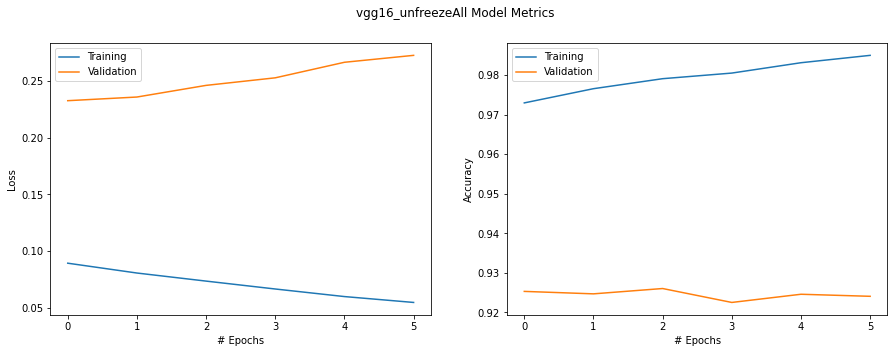

In [ ]:
title = "vgg16_unfreezeAll"
model.compile(loss='binary_crossentropy', 
                optimizer=SGD(lr=1e-4, momentum=0.9),
                metrics=['acc'])
fit(model, title)

In [ ]:
model_analysis(model, title)

Results for vgg16_unfreezeAll
38/37 [==============================] - 24s 633ms/step
Error rate 0.09034397016162453
              precision    recall  f1-score   support

      Female       0.80      0.86      0.83      2517
        Male       0.95      0.93      0.94      7135

    accuracy                           0.91      9652
   macro avg       0.88      0.89      0.89      9652
weighted avg       0.91      0.91      0.91      9652

Successfully saved auc_roc file at /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/results/vgg16_unfreezeAll_roc_auc


## Unfreeze only 1 set

In [ ]:
model = load_model("{}/weights/vgg16_optimal.h5".format(LINK_PREFIX))
model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in model.layers[0].layers[1:4]:
    layer.trainable = True
for layer in model.layers[0].layers[-4:]:
    layer.trainable = False
    
print("Total trainable weights: {}".format(len(model.trainable_weights)))
model.summary()

Total trainable weights: 10
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)             

Epoch 1/50
352/351 [==============================] - ETA: 0s - loss: 0.0920 - acc: 0.9730
Epoch 00001: val_acc improved from -inf to 0.92478, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/vgg16_unfreeze1Top.h5
352/351 [==============================] - 130s 370ms/step - loss: 0.0920 - acc: 0.9730 - val_loss: 0.2258 - val_acc: 0.9248
Epoch 2/50
352/351 [==============================] - ETA: 0s - loss: 0.0891 - acc: 0.9731
Epoch 00002: val_acc improved from 0.92478 to 0.92499, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/vgg16_unfreeze1Top.h5
352/351 [==============================] - 130s 370ms/step - loss: 0.0891 - acc: 0.9731 - val_loss: 0.2296 - val_acc: 0.9250
Epoch 3/50
352/351 [==============================] - ETA: 0s - loss: 0.0883 - acc: 0.9743
Epoch 00003: val_acc did not improve from 0.92499
352/351 [==============================] - 129s 366ms/step - loss: 0.0883 - acc: 0.9743 - val_loss: 0.2325 - val_acc

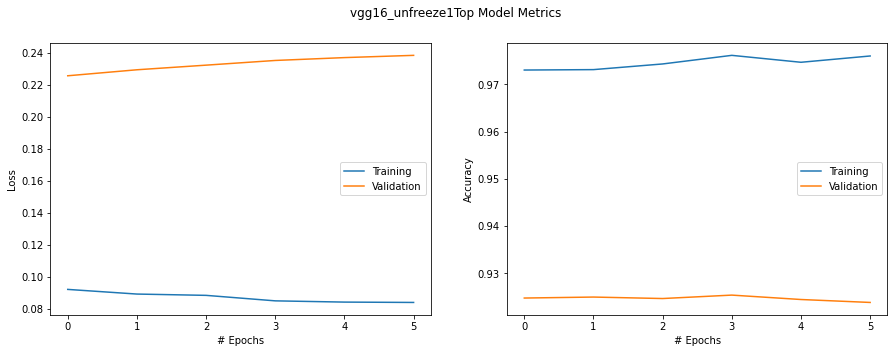

In [ ]:
title = "vgg16_unfreeze1Top"
model.compile(loss='binary_crossentropy', 
                optimizer=SGD(lr=1e-4, momentum=0.9),
                metrics=['acc'])
fit(model, title)

In [ ]:
model_analysis(model, title)

Results for vgg16_unfreeze1Top
151/150 [==============================] - 24s 157ms/step
Error rate 0.07521757148777455
              precision    recall  f1-score   support

      Female       0.89      0.82      0.85      2517
        Male       0.94      0.96      0.95      7135

    accuracy                           0.92      9652
   macro avg       0.91      0.89      0.90      9652
weighted avg       0.92      0.92      0.92      9652

Successfully saved auc_roc file at /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/results/vgg16_unfreeze1Top_roc_auc


## Unfreeze 2 sets

In [ ]:
model = load_model("{}/weights/vgg16_optimal.h5".format(LINK_PREFIX))
model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in model.layers[0].layers[1:4]:
    layer.trainable = True
    
print("Total trainable weights: {}".format(len(model.trainable_weights)))
model.summary()

Total trainable weights: 16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)             

Epoch 1/50
352/351 [==============================] - ETA: 0s - loss: 0.0885 - acc: 0.9738
Epoch 00001: val_acc improved from -inf to 0.92364, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/vgg16_unfreeze2Top.h5
352/351 [==============================] - 134s 380ms/step - loss: 0.0885 - acc: 0.9738 - val_loss: 0.2339 - val_acc: 0.9236
Epoch 2/50
352/351 [==============================] - ETA: 0s - loss: 0.0812 - acc: 0.9769
Epoch 00002: val_acc did not improve from 0.92364
352/351 [==============================] - 133s 377ms/step - loss: 0.0812 - acc: 0.9769 - val_loss: 0.2345 - val_acc: 0.9236
Epoch 3/50
352/351 [==============================] - ETA: 0s - loss: 0.0773 - acc: 0.9778
Epoch 00003: val_acc improved from 0.92364 to 0.92540, saving model to /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/weights/vgg16_unfreeze2Top.h5
352/351 [==============================] - 134s 382ms/step - loss: 0.0773 - acc: 0.9778 - val_loss: 0.2401 - val_acc

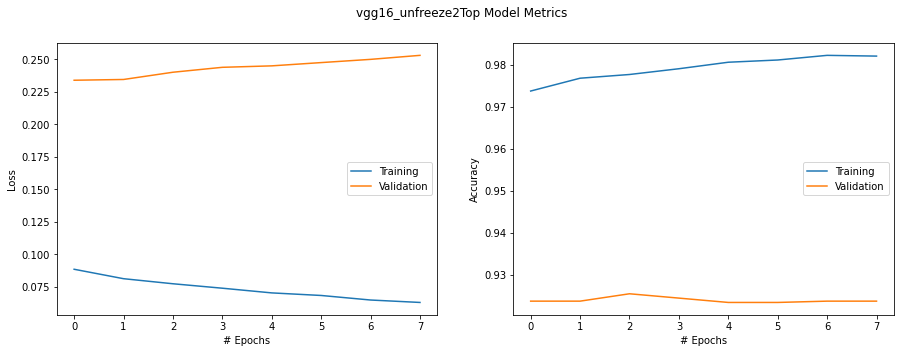

In [ ]:
title = "vgg16_unfreeze2Top"
model.compile(loss='binary_crossentropy', 
                optimizer=SGD(lr=1e-4, momentum=0.9),
                metrics=['acc'])
fit(model, title)

In [ ]:
model_analysis(model, title)

Results for vgg16_unfreeze2Top
151/150 [==============================] - 24s 159ms/step
Error rate 0.07459593866556154
              precision    recall  f1-score   support

      Female       0.89      0.82      0.85      2517
        Male       0.94      0.96      0.95      7135

    accuracy                           0.93      9652
   macro avg       0.91      0.89      0.90      9652
weighted avg       0.92      0.93      0.92      9652

Successfully saved auc_roc file at /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/results/vgg16_unfreeze2Top_roc_auc


# Evaluation

In [ ]:
from keras.models import load_model

In [ ]:
for model_name in histories.keys():
    model = load_model("{}/weights/{}.h5".format(LINK_PREFIX, model_name))
    model_analysis(model, model_name)

Results for EfficientNetB0
76/75 [==============================] - 25s 324ms/step
Error rate 0.2607749689183589
              precision    recall  f1-score   support

      Female       0.00      0.00      0.00      2517
        Male       0.74      1.00      0.85      7135

    accuracy                           0.74      9652
   macro avg       0.37      0.50      0.43      9652
weighted avg       0.55      0.74      0.63      9652



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successfully saved auc_roc file at /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/results/EfficientNetB0_roc_auc
Results for xception
76/75 [==============================] - 41s 540ms/step
Error rate 0.09469539991711562
              precision    recall  f1-score   support

      Female       0.85      0.77      0.81      2517
        Male       0.92      0.95      0.94      7135

    accuracy                           0.91      9652
   macro avg       0.89      0.86      0.87      9652
weighted avg       0.90      0.91      0.90      9652

Successfully saved auc_roc file at /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/results/xception_roc_auc
Results for vgg16
76/75 [==============================] - 39s 520ms/step
Error rate 0.07811852465810194
              precision    recall  f1-score   support

      Female       0.90      0.78      0.84      2517
        Male       0.93      0.97      0.95      7135

    accuracy                           0.92      9652
   m

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
validation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=256, 
                                                              class_mode='binary', shuffle=False)

model = load_model("{}/weights/vgg16_batch-size:256.h5".format(LINK_PREFIX))
model_analysis(model, "vgg16_batch-size:256")

Found 9652 validated image filenames belonging to 2 classes.
Results for vgg16_batch-size:256
38/37 [==============================] - 26s 686ms/step
Error rate 0.07874015748031496
              precision    recall  f1-score   support

      Female       0.90      0.78      0.84      2517
        Male       0.93      0.97      0.95      7135

    accuracy                           0.92      9652
   macro avg       0.91      0.88      0.89      9652
weighted avg       0.92      0.92      0.92      9652

Successfully saved auc_roc file at /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/results/vgg16_batch-size:256_roc_auc


In [ ]:
validation_generator = validation_datagen.flow_from_dataframe(val_df, 
                                                              x_col="path", y_col="gender", 
                                                              target_size=(224,224), batch_size=64, 
                                                              class_mode='binary', shuffle=False)

model = load_model("{}/weights/vgg16_batch-size:64.h5".format(LINK_PREFIX))
model_analysis(model, "vgg16_batch-size:64")

Found 9652 validated image filenames belonging to 2 classes.
Results for vgg16_batch-size:64
151/150 [==============================] - 25s 162ms/step
Error rate 0.07708246995441359
              precision    recall  f1-score   support

      Female       0.89      0.80      0.84      2517
        Male       0.93      0.96      0.95      7135

    accuracy                           0.92      9652
   macro avg       0.91      0.88      0.90      9652
weighted avg       0.92      0.92      0.92      9652

Successfully saved auc_roc file at /content/gdrive/My Drive/Colab Notebooks/CZ4042 Project/results/vgg16_batch-size:64_roc_auc
